## Simulated data LSTM test 

#### - [1] time series (n=4) of simulated data from Figure 3 of " Robust and Scalable Models of Microbiome Dynamics for Bacteriotherapy Design " of Travis E. Gibson, Georg K. Gerber

#### - [2] time series (n=13) of simulated data from Figure 4 of "Robust and Scalable Models of Microbiome Dynamics" of Travis E. Gibson, Georg K. Gerber

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.interpolate import UnivariateSpline as spline
from scipy.cluster.hierarchy import fcluster
from scipy import stats
import scipy.cluster.hierarchy as hac
from clstm import cLSTM, train_model_gista
import torch

### [1] time series (n=4) of simulated data from Figure 3 of " Robust and Scalable Models of Microbiome Dynamics for Bacteriotherapy Design " of Travis E. Gibson, Georg K. Gerber

[link to image](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/bd0fe950c9b6e25edc80c60685ae0047614b0b93/4-Figure3-1.png)

In [403]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/bd0fe950c9b6e25edc80c60685ae0047614b0b93/4-Figure3-1.png")

In [0]:
df={}
for i in range(1,5):
  df[i]=pd.read_csv('4_series_'+str(i)+'.csv',  names=['x', 'y'], header=None ) 
df[i].head()

,x,y
0,-3.783762,0.683112
1,10.921313,1.062619
2,17.961969,1.366224
3,42.952481,2.884250
4,49.369373,3.415560


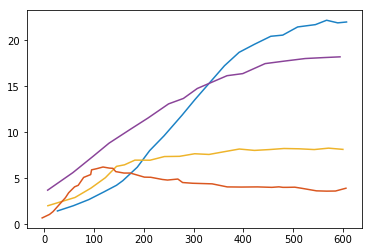

In [0]:
color = {
    1:  (  28/255,  130/255,  197/255),
    2:  ( 138/255,   68/255,  153/255),
    3:  ( 238/255,  180/255,  43/255),
    4:  ( 218/255,   87/255,  32/255)
}

for i in range(1,5):
  plt.plot(df[i].x,df[i].y, color=color[i])
plt.show()

In [0]:
i=3
f = spline(df[i].x, df[i].y, k = 5)
x_int = np.linspace(0,601, 601)
y_int = f(x_int)

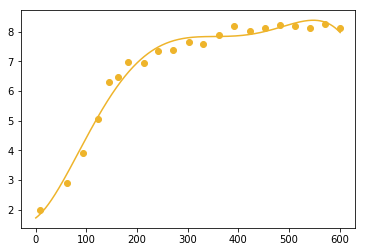

In [0]:
plt.plot(df[i].x,df[i].y, 'o', color=color[i])
plt.plot(x_int ,y_int , color=color[i])
plt.show()

In [0]:
Y=np.zeros((4,601))
x_int = np.linspace(0,601, 601)

for i in range(1,5):
  f = spline(df[i].x, df[i].y, k = 5)
  Y[i-1,:] = f(x_int)

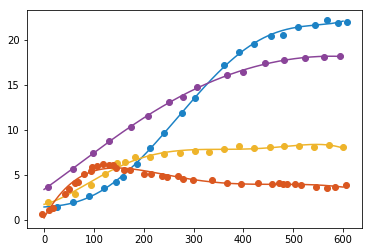

In [0]:
for i in range(1,5):
  plt.plot(Y[i-1,:], color=color[i])
for i in range(1,5):
  plt.plot(df[i].x,df[i].y, 'o',color=color[i])
plt.show()

In [0]:
def GC_adjust(lstm, threshold=True):
        '''Extract learned Granger causality.
        Args:
          threshold: return norm of weights, or whether norm is nonzero.
        Returns:
          GC: (p x p) matrix. Entry (i, j) indicates whether variable j is
            Granger causal of variable i.
        '''
        GC = [torch.sum(net.lstm.weight_ih_l0, dim=0)
              for net in lstm.networks]
        GC = torch.stack(GC)
        if threshold:
            return (GC > 0).int().cpu().data.numpy()
        else:
            return GC.cpu().data.numpy()
          
def plot_GC(lstm):
  f, ax = plt.subplots(1,2,figsize=(8, 4))
  GC= lstm.GC(threshold=False).cpu().data.numpy()
  im = ax[0].imshow(GC, cmap='Blues');
  f.colorbar(im, ax=ax[0]);

  GC= GC_adjust(lstm, threshold=False)
  im = ax[1].imshow(GC, cmap='coolwarm');
  f.colorbar(im, ax=ax[1]);
  f.tight_layout()

torch.Size([1, 601, 4])
----------Iter = 50----------
Total loss = 6.036999
MSE = 5.561691, Ridge = 0.001749, Nonsmooth = 0.473558
Variable usage = 100.00%


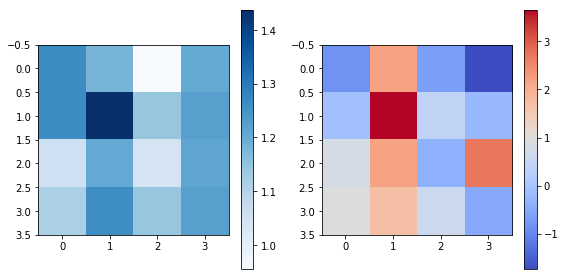

In [0]:
# 13 series
p = 4
n_hidden = 10

gcmodel = cLSTM(p, n_hidden)

top_5_reads = Y.T
X_torch = torch.tensor(top_5_reads[np.newaxis],  dtype=torch.float32)
print(X_torch.shape)

# Train with GISTA
check_every = 50
lam=0.1
lam_ridge=1e-4
lr=0.005
max_iter=50
truncation= 1

train_loss_list, train_mse_list = train_model_gista(
    gcmodel, X_torch, lam=lam, lam_ridge=lam_ridge, lr=lr, max_iter=max_iter, 
    check_every=check_every, monotone=monotone , truncation=truncation, switch_tol=switch_tol)
plot_GC(gcmodel)

----------Iter = 50----------
Total loss = 1.793022
MSE = 1.327402, Ridge = 0.002533, Nonsmooth = 0.463087
Variable usage = 100.00%
----------Iter = 50----------
Total loss = 1.075701
MSE = 0.619965, Ridge = 0.002860, Nonsmooth = 0.452876
Variable usage = 100.00%
----------Iter = 50----------
Total loss = 0.826512
MSE = 0.380146, Ridge = 0.003017, Nonsmooth = 0.443350
Variable usage = 100.00%
----------Iter = 50----------
Total loss = 0.731760
MSE = 0.294599, Ridge = 0.003107, Nonsmooth = 0.434054
Variable usage = 100.00%
----------Iter = 50----------
Total loss = 0.669858
MSE = 0.241832, Ridge = 0.003167, Nonsmooth = 0.424860
Variable usage = 100.00%


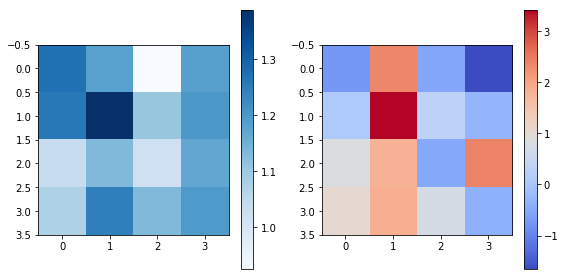

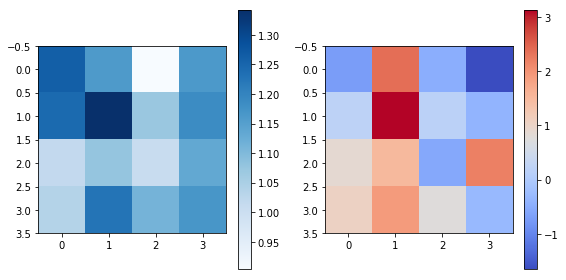

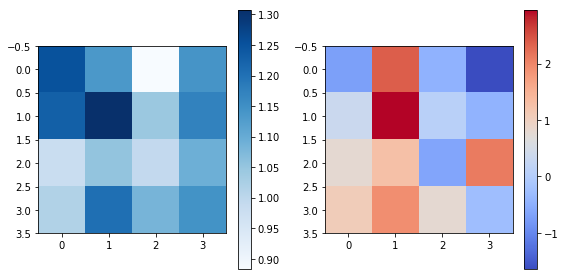

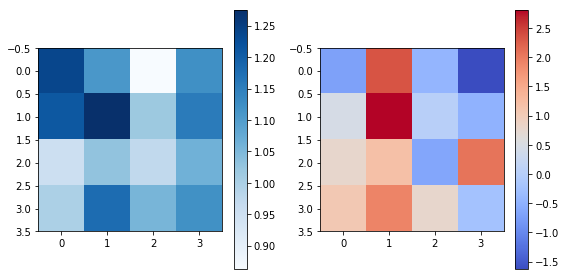

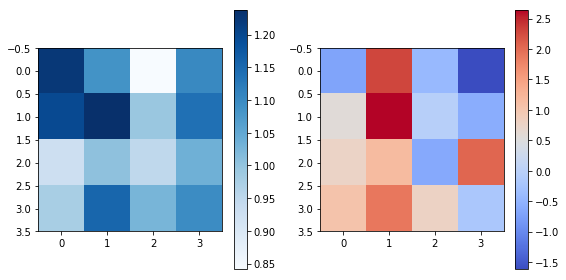

In [0]:
for i in range(0,5):
  train_loss_list, train_mse_list = train_model_gista(
      gcmodel, X_torch, lam=lam, lam_ridge=lam_ridge, lr=lr, max_iter=max_iter, 
      check_every=check_every, monotone=monotone , truncation=truncation, switch_tol=switch_tol)
  plot_GC(gcmodel)

The matrix should look like this: 

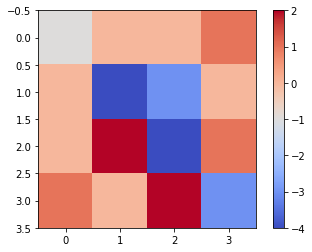

In [0]:
x=np.array([
    [-1,  0 , 0 , 1],
    [0 , -4 ,-3 , 0],
    [0 ,  2 ,-4 , 1],
    [1 ,  0 , 2 ,-3],
])
plt.imshow(x, cmap='coolwarm');
plt.colorbar();

### - [2] time series (n=13) of simulated data from Figure 4 of "Robust and Scalable Models of Microbiome Dynamics" of Travis E. Gibson, Georg K. Gerber

[link to image](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/af60e575721d3ef4bf2cf749f1a6024c2a3e4c8c/6-Figure4-1.png)

In [404]:
Image(url= "https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/af60e575721d3ef4bf2cf749f1a6024c2a3e4c8c/6-Figure4-1.png")

In [0]:
df={}
for i in range(1,14):
  df[i]=pd.read_csv(str(i)+'.csv',  names=['x', 'y'], header=None ) 
df[i].head()

,x,y
0,2.313280,4.154077
1,11.527844,3.504854
2,16.243472,3.294216
3,34.903738,2.675447
4,39.850504,2.505793


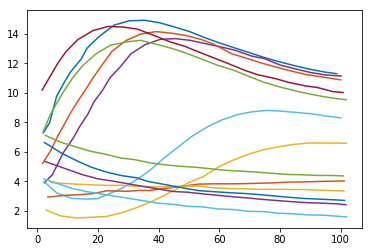

In [0]:
color = {
    1:  (  0/255, 114/255, 189/255),
    2:  (126/255,  48/255, 141/255),
    3:  (217/255,  82/255,  25/255),
    4:  (162/255,  18/255,  48/255),
    5:  (119/255, 172/255,  48/255),
    6:  ( 78/255, 190/255, 238/255),
    7:  (238/255, 177/255,  32/255),
    8:  (119/255, 172/255,  48/255),
    9:  (217/255,  82/255,  25/255),
    10: (238/255, 177/255,  32/255),
    11: (  0/255, 114/255, 189/255),
    12: (126/255,  48/255, 141/255),
    13: ( 78/255, 190/255, 238/255)
}

for i in range(1,14):
  plt.plot(df[i].x,df[i].y, color=color[i])
plt.show()

In [0]:
i=6
f = spline(df[i].x, df[i].y, k = 5)
x_int = np.linspace(0,101, 101)
y_int = f(x_int)

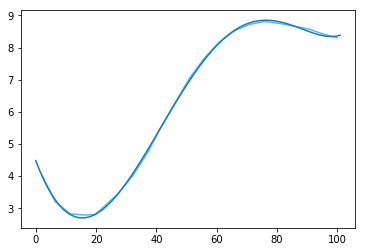

In [0]:
plt.plot(df[i].x,df[i].y, color=color[i])
plt.plot(x_int ,y_int )
plt.show()

In [0]:
Y=np.zeros((13,101))
x_int = np.linspace(0,100, 101)

for i in range(1,14):
  f = spline(df[i].x, df[i].y, k = 5)
  Y[i-1,:] = f(x_int)

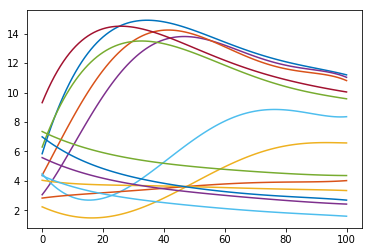

In [0]:
for i in range(1,14):
  plt.plot(Y[i-1,:], color=color[i])
plt.show()

In [0]:
def plot_dendrogram(Z):
  # Plot dendogram
  plt.figure(figsize=(15, 5))
  plt.title('Hierarchical Clustering Dendrogram')
  plt.xlabel('sample index')
  plt.ylabel('distance')
  hac.dendrogram(
      Z,
      leaf_rotation=90.,  # rotates the x axis labels
      leaf_font_size=8.,  # font size for the x axis labels
  )
  plt.show()

In [0]:
def print_clusters(timeSeries, Z, k, plot=False):
    # k Number of clusters I'd like to extract
    results = fcluster(Z, k, criterion='maxclust')

    # check the results
    s = pd.Series(results)
    clusters = s.unique()

    for c in clusters:
        cluster_indeces = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))
        if plot:
          for ind in cluster_indeces: 
            plt.plot(timeSeries.iloc[ind,:], color=color[ind+1], label=str(ind+1))
          plt.legend()
          plt.show()

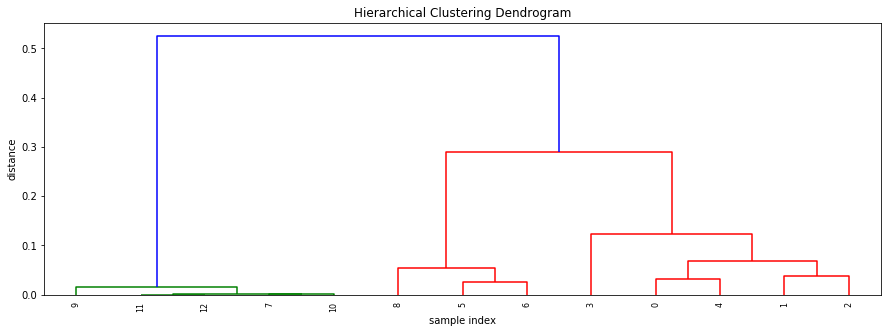

Cluster 3 number of entries 5
Cluster 2 number of entries 3
Cluster 1 number of entries 5

Lets print the different clusters:
Cluster 3 number of entries 5


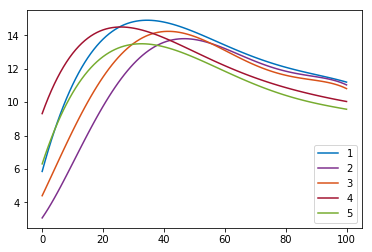

Cluster 2 number of entries 3


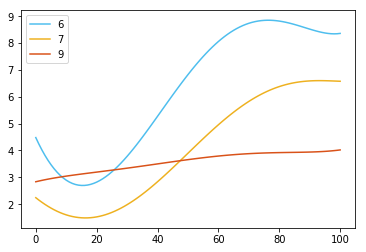

Cluster 1 number of entries 5


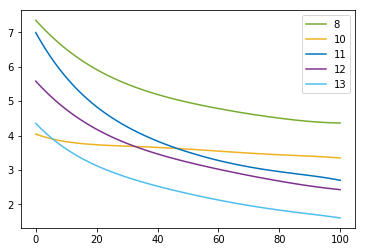

In [0]:
# Do the clustering
timeSeries = pd.DataFrame(Y)
Z = hac.linkage(timeSeries, method='single', metric='correlation')

plot_dendrogram(Z)
print_clusters(timeSeries, Z, 3, plot=False)

print('\nLets print the different clusters:')
print_clusters(timeSeries, Z, 3, plot=True)

**Changing params method='complete' to get rid of ligne 9 in cluster 2 (to get the same clusters as in paper)**

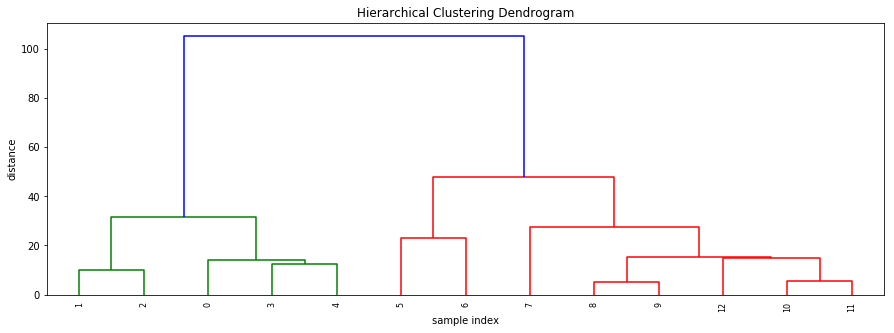

Cluster 1 number of entries 5
Cluster 2 number of entries 2
Cluster 3 number of entries 6

Lets print the different clusters:
Cluster 1 number of entries 5


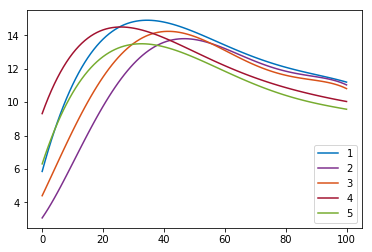

Cluster 2 number of entries 2


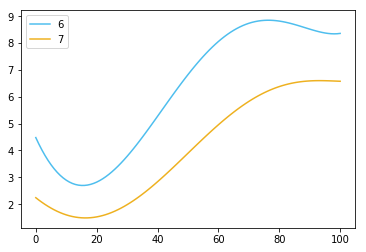

Cluster 3 number of entries 6


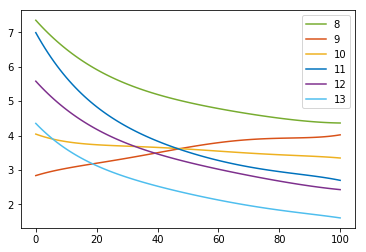

In [0]:
timeSeries = pd.DataFrame(Y)
Z = hac.linkage(timeSeries, method='complete')

plot_dendrogram(Z)
print_clusters(timeSeries, Z, 3, plot=False)

print('\nLets print the different clusters:')
print_clusters(timeSeries, Z, 3, plot=True)

In [0]:
def GC_adjust(lstm, threshold=True):
        '''Extract learned Granger causality.
        Args:
          threshold: return norm of weights, or whether norm is nonzero.
        Returns:
          GC: (p x p) matrix. Entry (i, j) indicates whether variable j is
            Granger causal of variable i.
        '''
        GC = [torch.sum(net.lstm.weight_ih_l0, dim=0)
              for net in lstm.networks]
        GC = torch.stack(GC)
        if threshold:
            return (GC > 0).int().cpu().data.numpy()
        else:
            return GC.cpu().data.numpy()
          
def plot_GC(lstm):
  f, ax = plt.subplots(1,2,figsize=(8, 4))
  GC= lstm.GC(threshold=False).cpu().data.numpy()
  im = ax[0].imshow(GC, cmap='Blues');
  f.colorbar(im, ax=ax[0]);

  GC= GC_adjust(lstm, threshold=False)
  im = ax[1].imshow(GC, cmap='coolwarm');
  f.colorbar(im, ax=ax[1]);
  f.tight_layout()

torch.Size([1, 101, 13])
----------Iter = 50----------
Total loss = 17.729723
MSE = 11.064103, Ridge = 0.000660, Nonsmooth = 6.664960
Variable usage = 100.00%
----------Iter = 100----------
Total loss = 9.317020
MSE = 3.454182, Ridge = 0.001096, Nonsmooth = 5.861742
Variable usage = 100.00%


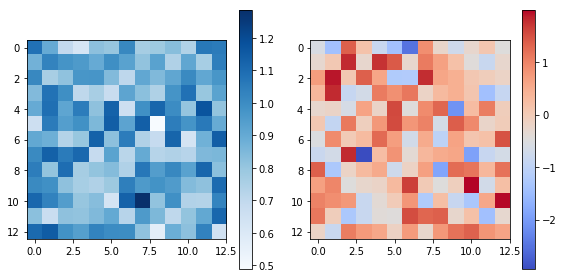

In [0]:
# 13 series
p = 13
n_hidden = 3

gcmodel = cLSTM(p, n_hidden)

top_5_reads = Y.T
X_torch = torch.tensor(top_5_reads[np.newaxis],  dtype=torch.float32)
print(X_torch.shape)

# Train with GISTA
check_every = 50
lam=0.5
lam_ridge=1e-4
lr=0.005
max_iter=100
monotone=True
truncation= 10
switch_tol=10e-3

train_loss_list, train_mse_list = train_model_gista(
    gcmodel, X_torch, lam=lam, lam_ridge=lam_ridge, lr=lr, max_iter=max_iter, 
    check_every=check_every, monotone=monotone , truncation=truncation, switch_tol=switch_tol)
plot_GC(gcmodel)

----------Iter = 50----------
Total loss = 7.090389
MSE = 1.718257, Ridge = 0.001287, Nonsmooth = 5.370845
Variable usage = 100.00%
----------Iter = 100----------
Total loss = 5.644792
MSE = 1.070206, Ridge = 0.001388, Nonsmooth = 4.573198
Variable usage = 100.00%
----------Iter = 50----------
Total loss = 4.856505
MSE = 1.011544, Ridge = 0.001457, Nonsmooth = 3.843504
Variable usage = 100.00%
----------Iter = 100----------
Total loss = 3.920177
MSE = 0.824287, Ridge = 0.001509, Nonsmooth = 3.094382
Variable usage = 100.00%
----------Iter = 50----------
Total loss = 3.311774
MSE = 0.757715, Ridge = 0.001559, Nonsmooth = 2.552500
Variable usage = 99.41%
----------Iter = 100----------
Total loss = 2.812322
MSE = 0.866592, Ridge = 0.001594, Nonsmooth = 1.944136
Variable usage = 94.08%
----------Iter = 50----------
Total loss = 2.172375
MSE = 0.716588, Ridge = 0.001606, Nonsmooth = 1.454180
Variable usage = 82.25%
----------Iter = 100----------
Total loss = 1.582992
MSE = 0.494570, Ridge =

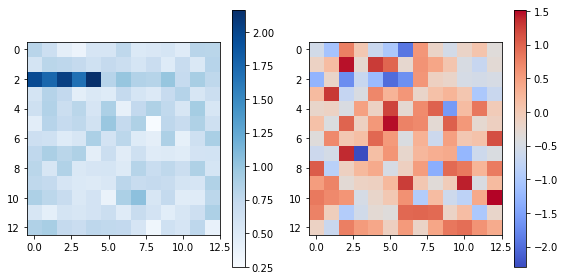

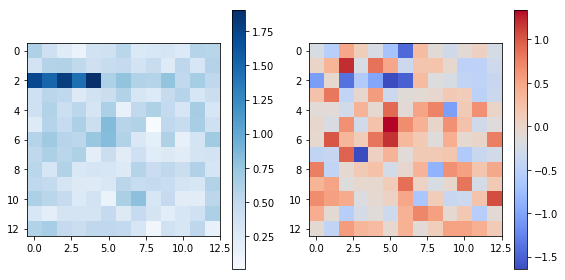

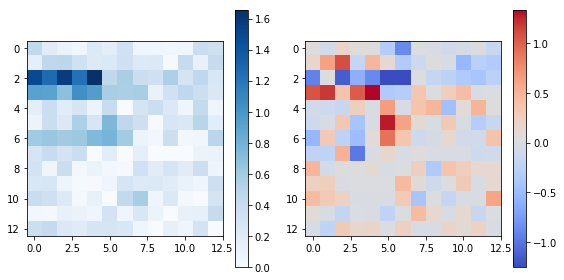

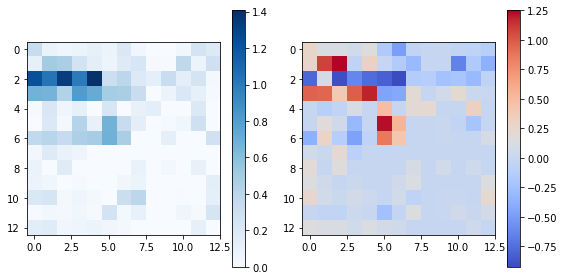

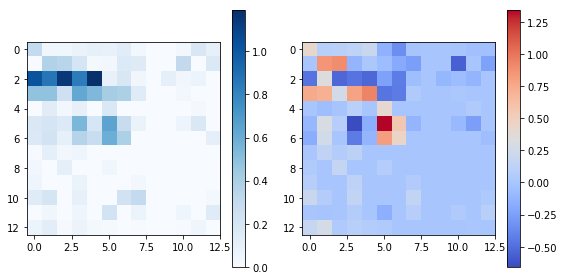

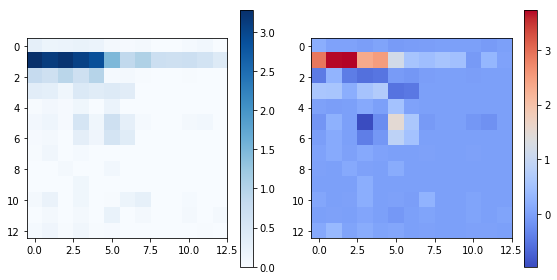

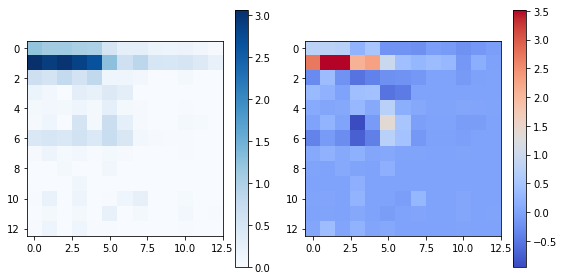

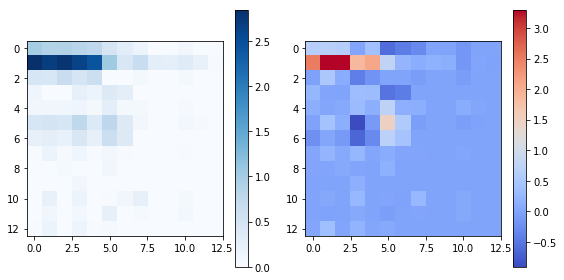

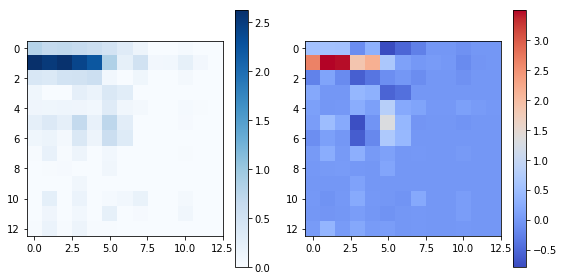

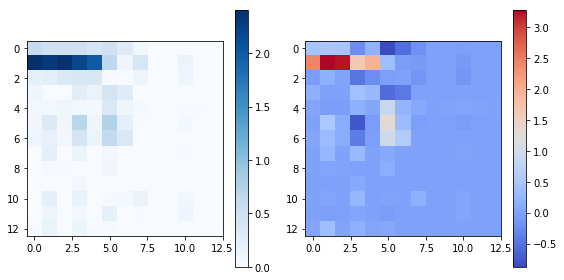

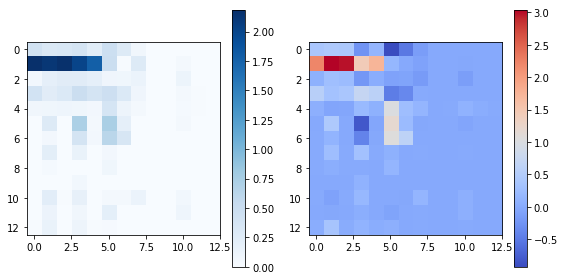

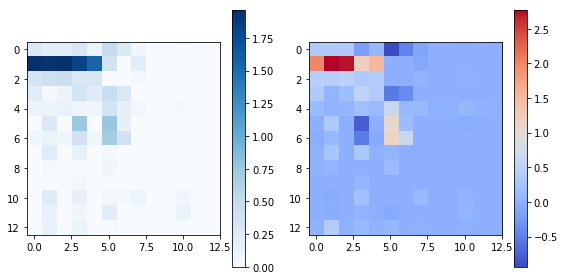

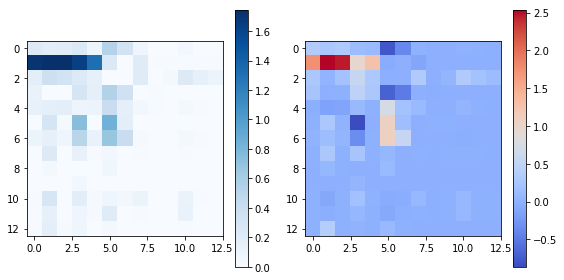

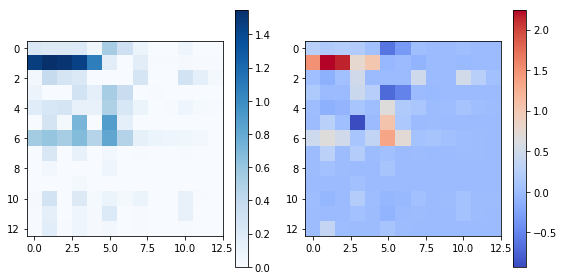

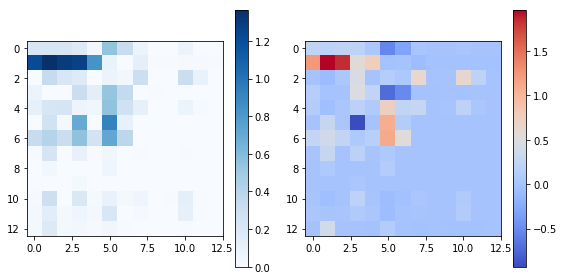

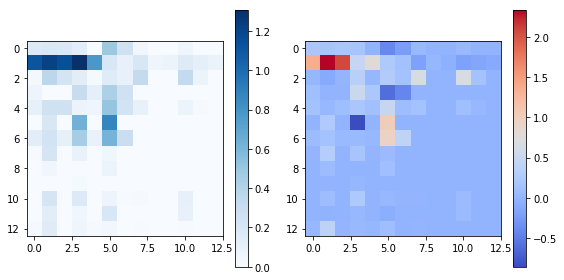

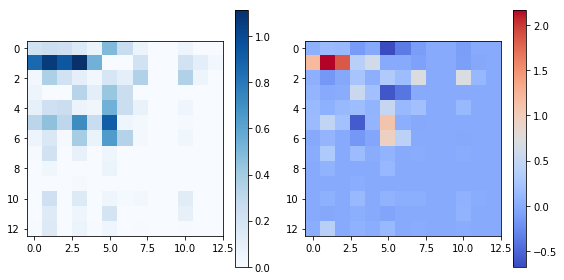

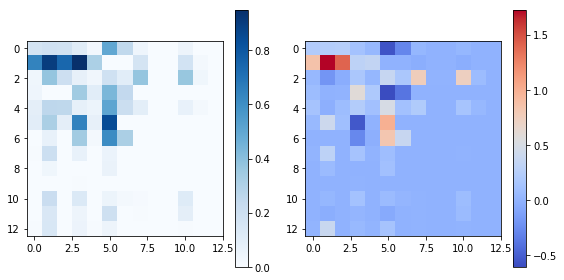

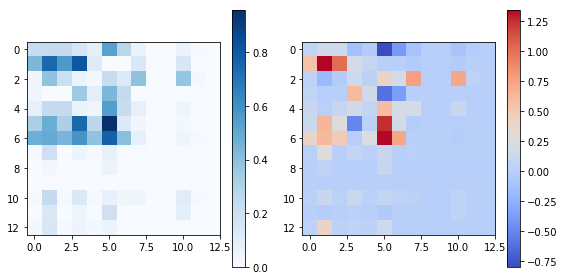

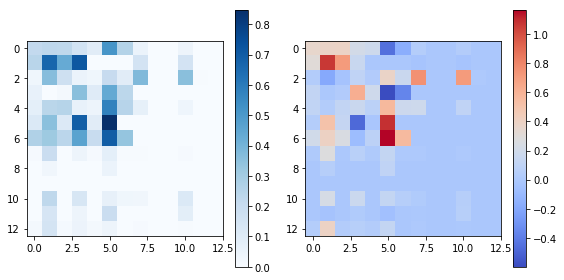

In [0]:
for i in range(0,20):
  train_loss_list, train_mse_list = train_model_gista(
      gcmodel, X_torch, lam=lam, lam_ridge=lam_ridge, lr=lr, max_iter=max_iter, 
      check_every=check_every, monotone=monotone , truncation=truncation, switch_tol=switch_tol)
  plot_GC(gcmodel)

torch.Size([1, 101, 13])
----------Iter = 25----------
Total loss = 58.783779
MSE = 28.871798, Ridge = 0.000258, Nonsmooth = 29.911724
Variable usage = 100.00%
----------Iter = 50----------
Total loss = 27.457829
MSE = 12.061397, Ridge = 0.000619, Nonsmooth = 15.395814
Variable usage = 99.41%


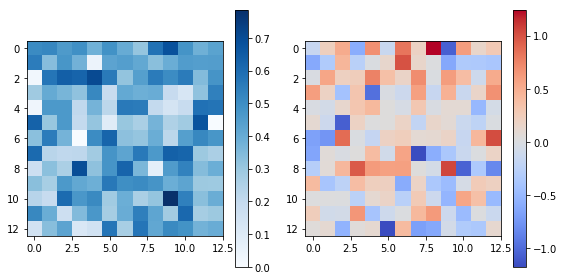

In [0]:
# 13 series
p = 13
n_hidden = 3

gcmodel = cLSTM(p, n_hidden)
top_5_reads = Y.T
X_torch = torch.tensor(top_5_reads[np.newaxis],  dtype=torch.float32)
print(X_torch.shape)

# Train with GISTA
check_every = 25
lam=3
lam_ridge=1e-4
lr=0.005
max_iter=50
monotone=True
truncation= 10
switch_tol=10e-3

train_loss_list, train_mse_list = train_model_gista(
    gcmodel, X_torch, lam=lam, lam_ridge=lam_ridge, lr=lr, max_iter=max_iter, 
    check_every=check_every, monotone=monotone , truncation=truncation, switch_tol=switch_tol)
plot_GC(gcmodel)

----------Iter = 25----------
Total loss = 10.829184
MSE = 4.663805, Ridge = 0.000915, Nonsmooth = 6.164464
Variable usage = 76.92%
----------Iter = 50----------
Total loss = 10.161051
MSE = 3.270681, Ridge = 0.001099, Nonsmooth = 6.889271
Variable usage = 47.93%
----------Iter = 25----------
Total loss = 7.018055
MSE = 2.367607, Ridge = 0.001226, Nonsmooth = 4.649222
Variable usage = 39.05%
----------Iter = 50----------
Total loss = 6.425457
MSE = 2.027633, Ridge = 0.001324, Nonsmooth = 4.396500
Variable usage = 39.05%
----------Iter = 25----------
Total loss = 10.100224
MSE = 4.317703, Ridge = 0.001380, Nonsmooth = 5.781140
Variable usage = 37.87%
Switching to line search


KeyboardInterrupt: ignored

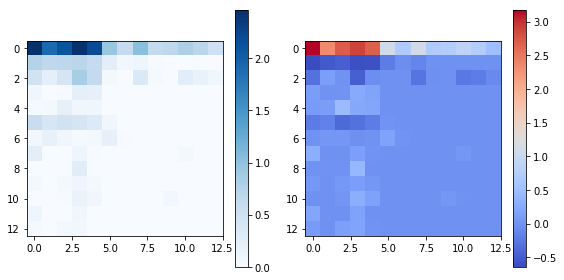

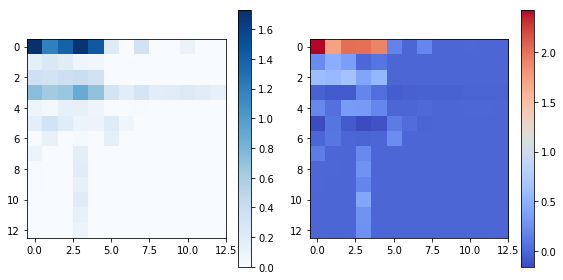

In [0]:
for i in range(0,3):
  train_loss_list, train_mse_list = train_model_gista(
      gcmodel, X_torch, lam=lam, lam_ridge=lam_ridge, lr=lr, max_iter=max_iter, 
      check_every=check_every, monotone=monotone , truncation=truncation, switch_tol=switch_tol)
  plot_GC(gcmodel)

The matrix should look like one of these two: 

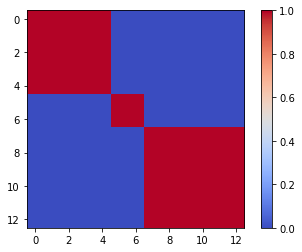

In [0]:
x=np.array([
    [1,1,1,1,1,0,0,0,0,0,0,0,0],
    [1,1,1,1,1,0,0,0,0,0,0,0,0],
    [1,1,1,1,1,0,0,0,0,0,0,0,0],
    [1,1,1,1,1,0,0,0,0,0,0,0,0],
    [1,1,1,1,1,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,1,1,0,0,0,0,0,0],
    [0,0,0,0,0,1,1,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,1,1,1,1,1,1],
    [0,0,0,0,0,0,0,1,1,1,1,1,1],
    [0,0,0,0,0,0,0,1,1,1,1,1,1],
    [0,0,0,0,0,0,0,1,1,1,1,1,1],
    [0,0,0,0,0,0,0,1,1,1,1,1,1],
    [0,0,0,0,0,0,0,1,1,1,1,1,1],
])
plt.imshow(x, cmap='coolwarm');
plt.colorbar();

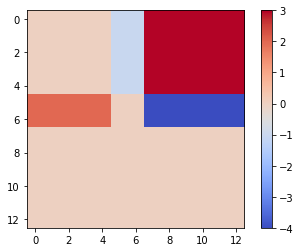

In [0]:
x=np.array([
    [0,0,0,0,0,-1,-1,3,3,3,3,3,3],
    [0,0,0,0,0,-1,-1,3,3,3,3,3,3],
    [0,0,0,0,0,-1,-1,3,3,3,3,3,3],
    [0,0,0,0,0,-1,-1,3,3,3,3,3,3],
    [0,0,0,0,0,-1,-1,3,3,3,3,3,3],
    [2,2,2,2,2,0,0,-4,-4,-4,-4,-4,-4],
    [2,2,2,2,2,0,0,-4,-4,-4,-4,-4,-4],
    [0,0,0,0,0,0,0, 0, 0, 0, 0, 0, 0],
    [0,0,0,0,0,0,0, 0, 0, 0, 0, 0, 0],
    [0,0,0,0,0,0,0, 0, 0, 0, 0, 0, 0],
    [0,0,0,0,0,0,0, 0, 0, 0, 0, 0, 0],
    [0,0,0,0,0,0,0, 0, 0, 0, 0, 0, 0],
    [0,0,0,0,0,0,0, 0, 0, 0, 0, 0, 0],
])
plt.imshow(x, cmap='coolwarm');
plt.colorbar();

In [0]:
# 3 series: collapsing all the 13 into 3 by just taking 1 from every cluster
p = 3
n_hidden = 3

gcmodel = cLSTM(p, n_hidden)

top_5_reads = Y[[0,5,10],:].T
X_torch = torch.tensor(top_5_reads[np.newaxis],  dtype=torch.float32)
print(X_torch.shape)

# Train with GISTA
check_every = 100
lam=0.1
lam_ridge=10e-4
lr=0.005
max_iter=200
monotone=True
truncation= 1
switch_tol=10e-3

for i in range(0,2):
  train_loss_list, train_mse_list = train_model_gista(
      gcmodel, X_torch, lam=lam, lam_ridge=lam_ridge, lr=lr, max_iter=max_iter, 
      check_every=check_every, monotone=monotone , truncation=truncation, switch_tol=switch_tol)
  plot_GC(gcmodel)

In [0]:
for i in range(0,10):
  train_loss_list, train_mse_list = train_model_gista(
      gcmodel, X_torch, lam=lam, lam_ridge=lam_ridge, lr=lr, max_iter=max_iter, 
      check_every=check_every, monotone=monotone , truncation=truncation, switch_tol=switch_tol)
  plot_GC(gcmodel)

The matrix should look like: 


\begin{bmatrix}
    x      & -1 & 3  \\
    2     & x & -4  \\
    0      & 0 & x  \\
\end{bmatrix}

 -------
 
 [Link to Collab Notebook](https://colab.research.google.com/drive/1q86R9y77dyvDgq105ujs3qjCFAt2hdkh)
 
 --------